In [269]:
!mkdir ../dataset 
!wget -O ../dataset/KDDTrain+.txt https://raw.githubusercontent.com/acen20/DEL/master/deep-ensemble-jet/dataset/KDDTrain%2B.txt
!wget -O ../dataset/KDDTest+.txt https://raw.githubusercontent.com/acen20/DEL/master/deep-ensemble-jet/dataset/KDDTest%2B.txt
!wget -O ../dataset/KDDTrain+_20Percent.txt https://raw.githubusercontent.com/acen20/DEL/master/deep-ensemble-jet/dataset/KDDTrain%2B_20Percent.txt
!wget -O ../dataset/KDDTest-21.txt https://raw.githubusercontent.com/acen20/DEL/master/deep-ensemble-jet/dataset/KDDTest-21.txt

mkdir: cannot create directory ‘../dataset’: File exists
--2022-03-06 09:13:28--  https://raw.githubusercontent.com/acen20/DEL/master/deep-ensemble-jet/dataset/KDDTrain%2B.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19109424 (18M) [text/plain]
Saving to: ‘../dataset/KDDTrain+.txt’

../dataset/KDDTrain 100%[===================>]  18.22M  --.-KB/s    in 0.1s    

2022-03-06 09:13:29 (141 MB/s) - ‘../dataset/KDDTrain+.txt’ saved [19109424/19109424]

--2022-03-06 09:13:29--  https://raw.githubusercontent.com/acen20/DEL/master/deep-ensemble-jet/dataset/KDDTest%2B.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|1

In [270]:
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold as KFold
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

In [271]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [272]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Loading Dataset
# Dataset link: https://data.mendeley.com/datasets/xvyv59vwvz/1
# Dataset is present in the current directory containing the code file.
df=pd.read_csv('../dataset/KDDTrain+.txt', header=None)
df2=pd.read_csv('../dataset/KDDTest+.txt', header=None)

## Preprocessing

In [273]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [274]:
df.columns = [str(i) for i in range(0, len(df.columns))]
df2.columns = [str(i) for i in range(0, len(df2.columns))]

In [275]:
# Replacing Null values with 0. ML classifer cannot learn on Null values
df.fillna(0, inplace=True)
df2.fillna(0, inplace=True)

In [276]:
# Peak on dataset
df.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [277]:
df.shape

(125973, 43)

In [278]:
# Peak on the dataset
df.drop('42',axis=1, inplace=True)
df2.drop('42',axis=1, inplace=True)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [279]:
sub_classes = df.iloc[:,41].value_counts()

In [280]:
print(sub_classes)

normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: 41, dtype: int64


In [281]:
r2l = ['ftp_write','guess_passwd', 'imap', 'multihop', 'phf', 'spy','warezclient','warezmaster','xlock', 'xsnoop','named',
       'sendmail','snmpgetattack', 'snmpguess','httptunnel']
u2r = ['buffer_overflow', 'loadmodule','perl','ps','rootkit','sqlattack','xterm']
dos = ['back', 'land', 'neptune', 'smurf', 'teardrop','pod','mailbomb', 'processtable','udpstorm', 'worm','apache2']
probe = ['ipsweep', 'nmap', 'portsweep', 'satan','saint','mscan']

In [282]:
df['41'] = df['41'].map(
    lambda x: 'malicious' if x in r2l 
    else 'malicious' if x in u2r 
    else 'malicious' if x in dos 
    else 'malicious' if x in probe 
    else 'normal' if x is 'normal'
    else x
    )

df2['41'] = df2['41'].map(
    lambda x: 'malicious' if x in r2l 
    else 'malicious' if x in u2r 
    else 'malicious' if x in dos 
    else 'malicious' if x in probe 
    else 'normal' if x is 'normal'
    else x
    )

### Training set value counts

In [283]:
print(df['41'].value_counts())

normal       67343
malicious    58630
Name: 41, dtype: int64


### Testing set value counts

In [284]:
print(df2['41'].value_counts())

malicious    12833
normal        9711
Name: 41, dtype: int64


In [285]:
# Encodings Labels so that they are compatible with machine leanring classifiers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for i in df:
    if df[i].dtype=='object':
        df[i] = le.fit_transform(df[i])
    else:
        continue
for i in df2:
    if df2[i].dtype=='object':
        df2[i] = le.fit_transform(df2[i])
    else:
        continue
        
X_train = df.drop(['41'],axis=1)
y_train = df['41']

X_test = df2.drop(['41'],axis=1)
y_test = df2['41']

In [286]:
# Scaling data. Default scaling is to scale the data to unit variance (or equivalent
mms = MinMaxScaler()
X_train = mms.fit_transform(X_train)
X_train = torch.tensor(X_train, dtype=torch.float)

X_test = mms.fit_transform(X_test)
X_test = torch.tensor(X_test, dtype=torch.float)

## **Sparse AE**



In [287]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
pt_x_train = X_train.to(device)
pt_y_train = torch.tensor(y_train, dtype=torch.float).type(torch.LongTensor).to(device)
X_test = X_test.to(device)
y_test = torch.tensor(y_test, dtype=torch.float).type(torch.LongTensor).to(device)
pt_train = TensorDataset(pt_x_train, pt_y_train)
pt_train = DataLoader(pt_train, batch_size=64)
current_dims = 41

In [288]:
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Linear(current_dims, 15),
        nn.ReLU(),
        nn.BatchNorm1d(15)
    )
    self.bottleneck = nn.Sequential(
        nn.Linear(15, 15),
        nn.Sigmoid()
    )

  def forward(self, x):
    encoded = self.encoder(x)
    encoded = self.bottleneck(encoded)
    return encoded

In [289]:
class Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.decoder = nn.Sequential(
        nn.Linear(15, current_dims),
        nn.Sigmoid(),
    )

  def forward(self, x):
    decoded = self.decoder(x)
    return decoded

In [290]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
parameters = list(encoder.parameters())+ list(decoder.parameters())
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr = 4e-3, weight_decay=10e-5)

In [291]:
num_epochs = 10
outputs = []
losses = []
for epoch in range(num_epochs):
  for instance,_ in pt_train:
    encoded = encoder(instance)
    reconstructed = decoder(encoded)
    loss = criterion(reconstructed, instance)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  losses.append(loss.item())
  print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')

Epoch:1, Loss:0.0095
Epoch:2, Loss:0.0090
Epoch:3, Loss:0.0084
Epoch:4, Loss:0.0083
Epoch:5, Loss:0.0082
Epoch:6, Loss:0.0081
Epoch:7, Loss:0.0080
Epoch:8, Loss:0.0080
Epoch:9, Loss:0.0080
Epoch:10, Loss:0.0080


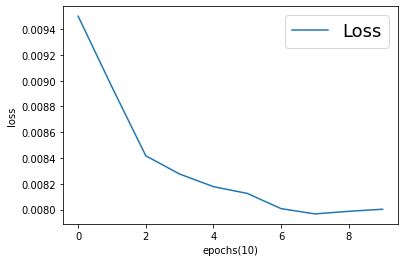

In [292]:
plt.plot(losses)
plt.xlabel(f"epochs({num_epochs})")
plt.ylabel(f"loss")
_ = plt.legend(['Loss'])

In [293]:
encoder.eval()
with torch.no_grad():
  train_X = encoder(X_train.to(device)).cpu()
  X_test = encoder(X_test.to(device)).cpu()

In [294]:
pt_train = TensorDataset(train_X, torch.tensor(y_train, dtype=torch.float))
pt_train = DataLoader(pt_train, batch_size=64)

In [295]:
class MLP(nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.model = nn.Sequential(
        nn.Linear(15, 128),
        nn.ReLU(),
        nn.BatchNorm1d(128),
        nn.Linear(128, 40),
        nn.ReLU(),
        nn.BatchNorm1d(40)
    )
    self.clf = nn.Sequential(
        nn.Linear(40, 1),
        nn.Sigmoid()
    )
  def forward(self, x):
      output = self.model(x)
      return self.clf(output)

In [296]:
mlp = MLP()
epochs = 20
lr = 4e-3
optimizer = torch.optim.Adam(mlp.parameters(), lr = lr)
criterion = nn.BCELoss()

In [297]:
losses = []
for epoch in range(epochs):
  for batch_idx, (x, target) in enumerate(pt_train):
    output = mlp(x)
    loss = criterion(output, target.view(-1,1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if batch_idx == 0:
      print(
          f"Epoch [{epoch+1}/{epochs}] \ "
          f"Loss: {loss.item():.4f}"
      ) 
      losses.append(loss.item())

Epoch [1/20] \ Loss: 0.5702
Epoch [2/20] \ Loss: 0.0938
Epoch [3/20] \ Loss: 0.0910
Epoch [4/20] \ Loss: 0.0691
Epoch [5/20] \ Loss: 0.0539
Epoch [6/20] \ Loss: 0.0599
Epoch [7/20] \ Loss: 0.0604
Epoch [8/20] \ Loss: 0.0550
Epoch [9/20] \ Loss: 0.0701
Epoch [10/20] \ Loss: 0.0860
Epoch [11/20] \ Loss: 0.0598
Epoch [12/20] \ Loss: 0.0725
Epoch [13/20] \ Loss: 0.0584
Epoch [14/20] \ Loss: 0.0662
Epoch [15/20] \ Loss: 0.0693
Epoch [16/20] \ Loss: 0.0590
Epoch [17/20] \ Loss: 0.0621
Epoch [18/20] \ Loss: 0.0582
Epoch [19/20] \ Loss: 0.0511
Epoch [20/20] \ Loss: 0.0618


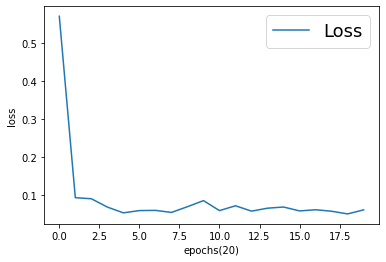

In [298]:
plt.plot(losses)
plt.xlabel(f"epochs({epochs})")
plt.ylabel(f"loss")
_ = plt.legend(['Loss'])

In [299]:
_ = mlp.eval()
with torch.no_grad():
  lr_probs_1 = mlp(X_test).squeeze()
  ml_pred = lr_probs_1.round()

In [300]:
cm = confusion_matrix(y_test, ml_pred)
tn=cm[0][0] #tn
fn=cm[0][1] #fn
fp=cm[1][0] #fp
tp=cm[1][1] #tp
acc= (tp+tn)/(tp+tn+fn+fp)
epsilon = 1e-7 # is used so that to avoid divide by zero error
precision = tp / (tp + fp + epsilon)
recall = tp / (tp + fn + epsilon)
sensitivity,specificity = tp/(tp+fn),tn/(tn+fp)
print("Test accuracy is:"+str(format(acc,'.4f')))
print("Precision: "+str(format(precision,'.4f'))+" Recall: "+str(format(recall,'.4f')))

Test accuracy is:0.7682
Precision: 0.9681 Recall: 0.6567


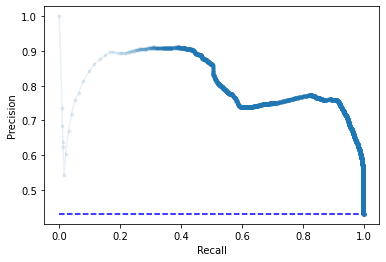

F1:	 78.254%
AUC:	 80.720%
Accuracy:76.823%


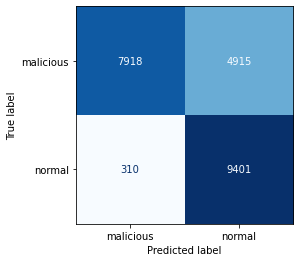

In [301]:
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs_1)
lr_f1, lr_auc = f1_score(y_test, ml_pred), auc(lr_recall, lr_precision)
no_skill = len(y_test[y_test==1]) / len(y_test)
acc = accuracy_score(y_test, ml_pred)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', c = "blue")
plt.plot(lr_recall, lr_precision, marker='.', alpha=0.1)
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')

# show the plot
plt.show()
_ = plt.rc('legend', fontsize=18)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = le.classes_)
disp.plot(cmap="Blues", colorbar = False)
print(f"F1:\t {lr_f1*100:.3f}%")
print(f"AUC:\t {lr_auc*100:.3f}%")
print(f"Accuracy:{acc*100:.3f}%")

In [302]:
torch.save(encoder.state_dict(), 'sparse_encoder.pt')